# Cross-Dataset Generalization Test

Test MVTec-trained models (CAE, VAE, DAE) on **KolektorSDD2** dataset.

This evaluates how well models generalize to unseen industrial defects.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, OUTPUTS_DIR, MVTEC_CATEGORIES, ensure_dirs
from src.data import KolektorDataset
from src.data.transforms import denormalize
from src.models import create_cae, create_vae, create_denoising_ae

ensure_dirs()
print(f"Device: {DEVICE}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


## 1. Explore Kolektor Dataset

In [ ]:
# Load Kolektor test set
kolektor_test = KolektorDataset(split='test', return_mask=True)
kolektor_loader = torch.utils.data.DataLoader(kolektor_test, batch_size=16, shuffle=False)

n_defect = sum(kolektor_test.labels)
n_normal = len(kolektor_test) - n_defect

print(f"Kolektor Test Set:")
print(f"  Total samples: {len(kolektor_test)}")
print(f"  Normal: {n_normal} ({100*n_normal/len(kolektor_test):.1f}%)")
print(f"  Defect: {n_defect} ({100*n_defect/len(kolektor_test):.1f}%)")

Kolektor Test Set:
  Total samples: 1004
  Normal: 894 (89.0%)
  Defect: 110 (11.0%)


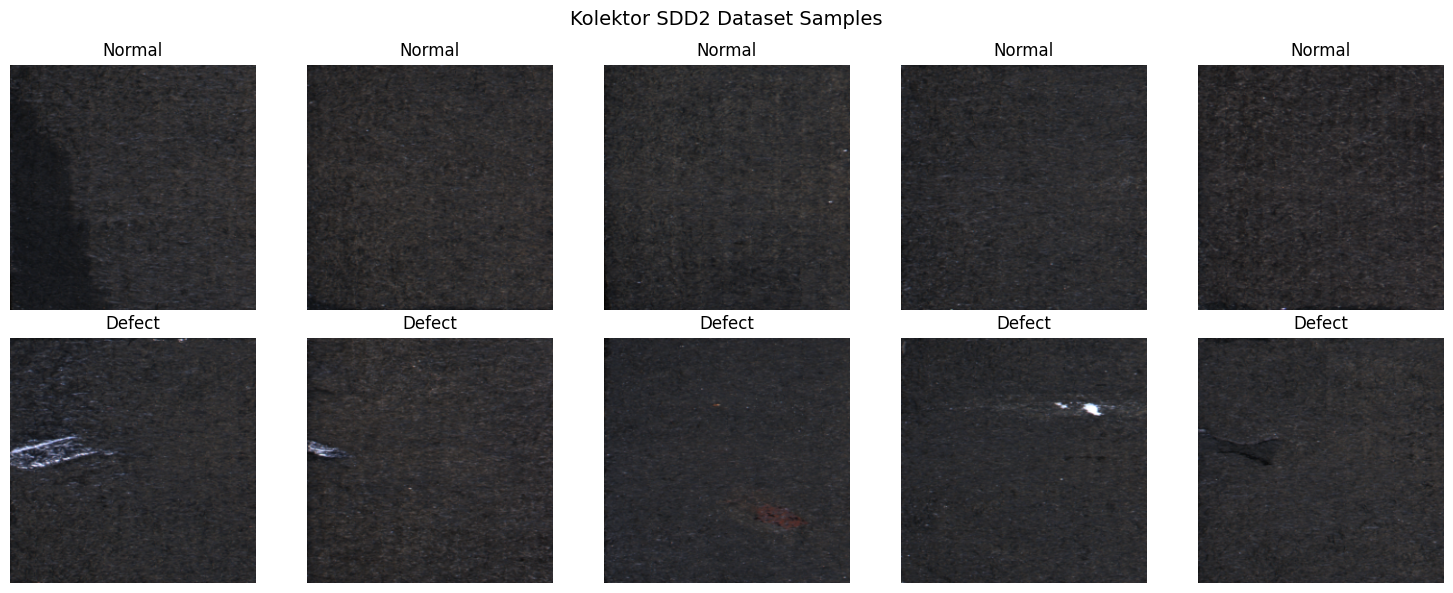

In [ ]:
# Visualize Kolektor samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Find some defect samples
defect_indices = [i for i, l in enumerate(kolektor_test.labels) if l == 1][:5]
normal_indices = [i for i, l in enumerate(kolektor_test.labels) if l == 0][:5]

for col, idx in enumerate(normal_indices):
    img, mask, label = kolektor_test[idx]
    img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
    axes[0, col].imshow(img_np)
    axes[0, col].set_title('Normal')
    axes[0, col].axis('off')

for col, idx in enumerate(defect_indices):
    img, mask, label = kolektor_test[idx]
    img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
    axes[1, col].imshow(img_np)
    axes[1, col].set_title('Defect')
    axes[1, col].axis('off')

plt.suptitle('Kolektor SDD2 Dataset Samples', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'kolektor_samples.png', dpi=150)
plt.show()

## 2. Load MVTec-Trained Models

In [ ]:
# Categories to test
test_categories = ['bottle', 'grid', 'metal_nut', 'tile', 'wood', 'carpet', 'leather']

def load_model(model_type, category):
    """Load a trained model."""
    if model_type == 'CAE':
        path = MODELS_DIR / f'cae_{category}_final.pth'
        model = create_cae()
    elif model_type == 'VAE':
        path = MODELS_DIR / f'vae_{category}_final.pth'
        model = create_vae()
    elif model_type == 'DAE':
        path = MODELS_DIR / f'dae_{category}_final.pth'
        model = create_denoising_ae()
    else:
        return None
    
    if path.exists():
        checkpoint = torch.load(path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        return model
    return None

print("Testing categories:", test_categories)

Testing categories: ['bottle', 'grid', 'metal_nut', 'tile', 'wood', 'carpet', 'leather']


## 3. Evaluate Generalization

In [ ]:
def evaluate_on_kolektor(model, model_type):
    """Evaluate a model on Kolektor dataset."""
    model.eval()
    all_scores, all_labels = [], []
    
    with torch.no_grad():
        for img, mask, label in kolektor_loader:
            img = img.to(DEVICE)
            
            if model_type == 'VAE':
                scores = model.get_anomaly_score(img)
            else:
                scores = model.get_reconstruction_error(img, reduction='mean')
            
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(label.numpy())
    
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except:
        auc = np.nan
    
    return auc, np.array(all_labels), np.array(all_scores)

# Evaluate all models
results = []
roc_data = {}  # For ROC curve plotting

for category in tqdm(test_categories, desc='Categories'):
    for model_type in ['CAE', 'VAE', 'DAE']:
        model = load_model(model_type, category)
        if model is not None:
            auc, labels, scores = evaluate_on_kolektor(model, model_type)
            results.append({
                'trained_on': category,
                'model': model_type,
                'kolektor_auc': auc
            })
            # Store for ROC plotting
            roc_data[f"{model_type}_{category}"] = (labels, scores)
            print(f"{model_type} ({category}) -> Kolektor AUC: {auc:.4f}")

df_results = pd.DataFrame(results)
display(df_results)

Categories:   0%|          | 0/7 [00:00<?, ?it/s]

CAE (bottle) -> Kolektor AUC: 0.6374
VAE (bottle) -> Kolektor AUC: nan


Categories:  14%|█▍        | 1/7 [00:42<04:12, 42.14s/it]

DAE (bottle) -> Kolektor AUC: 0.6094
CAE (grid) -> Kolektor AUC: 0.6901
VAE (grid) -> Kolektor AUC: nan


Categories:  29%|██▊       | 2/7 [01:24<03:30, 42.16s/it]

DAE (grid) -> Kolektor AUC: 0.6876
CAE (metal_nut) -> Kolektor AUC: 0.6220
VAE (metal_nut) -> Kolektor AUC: nan


Categories:  43%|████▎     | 3/7 [02:09<02:54, 43.70s/it]

DAE (metal_nut) -> Kolektor AUC: 0.6172
CAE (tile) -> Kolektor AUC: 0.6488
VAE (tile) -> Kolektor AUC: 0.5317


Categories:  57%|█████▋    | 4/7 [02:52<02:09, 43.23s/it]

DAE (tile) -> Kolektor AUC: 0.5752
CAE (wood) -> Kolektor AUC: 0.6624
VAE (wood) -> Kolektor AUC: nan


Categories:  71%|███████▏  | 5/7 [03:35<01:26, 43.02s/it]

DAE (wood) -> Kolektor AUC: 0.6516
CAE (carpet) -> Kolektor AUC: 0.6646
VAE (carpet) -> Kolektor AUC: 0.5358


Categories:  86%|████████▌ | 6/7 [04:17<00:42, 42.96s/it]

DAE (carpet) -> Kolektor AUC: 0.6825
CAE (leather) -> Kolektor AUC: 0.6683
VAE (leather) -> Kolektor AUC: 0.5323


Categories: 100%|██████████| 7/7 [05:00<00:00, 42.97s/it]

DAE (leather) -> Kolektor AUC: 0.6463


,trained_on,model,kolektor_auc
0,bottle,CAE,0.637436
1,bottle,VAE,NaN
2,bottle,DAE,0.609365
3,grid,CAE,0.690096
4,grid,VAE,NaN
5,grid,DAE,0.687584
6,metal_nut,CAE,0.622026
7,metal_nut,VAE,NaN
8,metal_nut,DAE,0.617195
9,tile,CAE,0.648820


## 4. Results Visualization

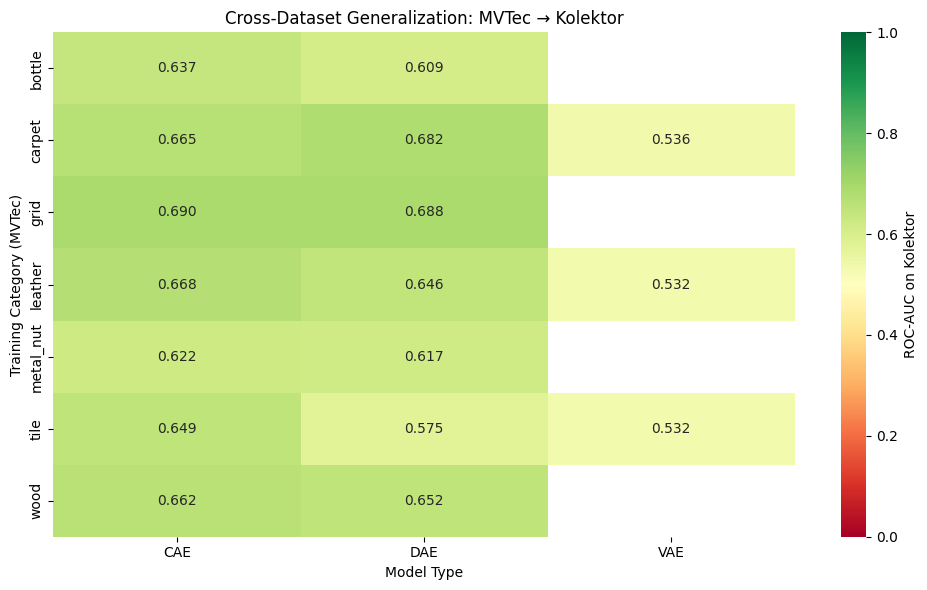

In [ ]:
# Pivot table heatmap
if not df_results.empty:
    pivot = df_results.pivot(index='trained_on', columns='model', values='kolektor_auc')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, ax=ax,
                cbar_kws={'label': 'ROC-AUC on Kolektor'})
    ax.set_title('Cross-Dataset Generalization: MVTec → Kolektor')
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Training Category (MVTec)')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'cross_dataset_heatmap.png', dpi=150)
    plt.show()

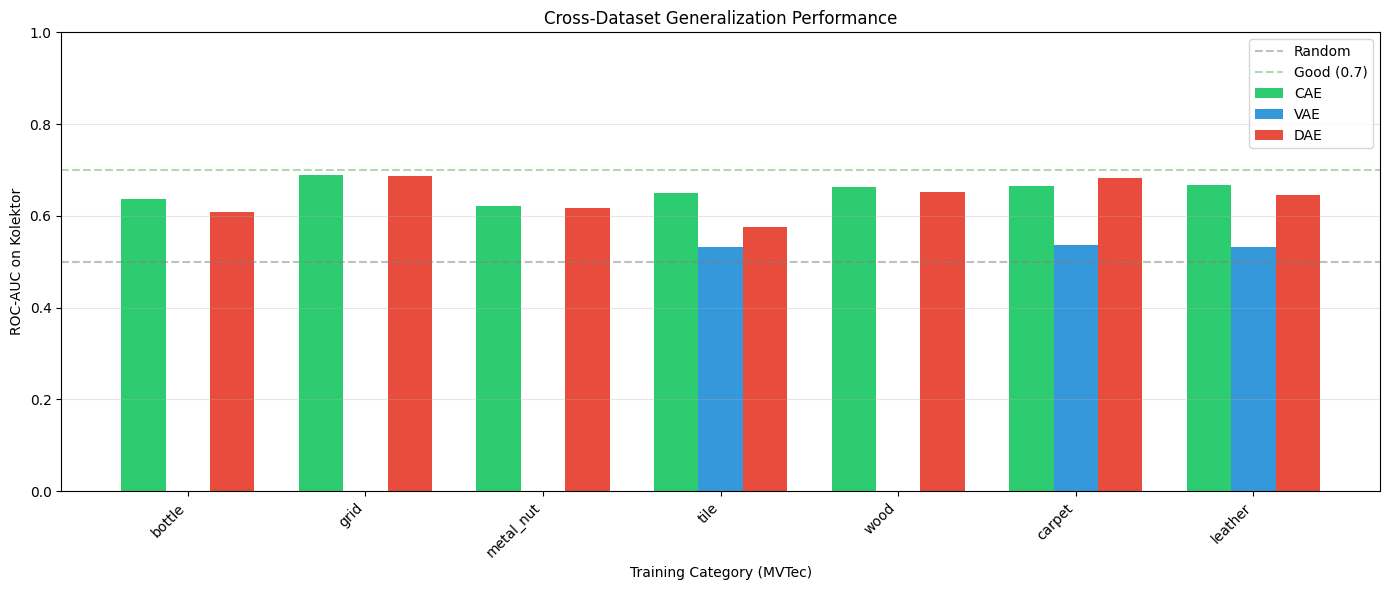

In [ ]:
# Bar chart comparison
if not df_results.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    categories = df_results['trained_on'].unique()
    x = np.arange(len(categories))
    width = 0.25
    colors = {'CAE': '#2ecc71', 'VAE': '#3498db', 'DAE': '#e74c3c'}
    
    for i, model_type in enumerate(['CAE', 'VAE', 'DAE']):
        aucs = []
        for cat in categories:
            val = df_results[(df_results['trained_on'] == cat) & (df_results['model'] == model_type)]['kolektor_auc'].values
            aucs.append(val[0] if len(val) > 0 and not np.isnan(val[0]) else 0)
        
        offset = (i - 1) * width
        ax.bar(x + offset, aucs, width, label=model_type, color=colors[model_type])
    
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    ax.axhline(0.7, color='green', linestyle='--', alpha=0.3, label='Good (0.7)')
    
    ax.set_xlabel('Training Category (MVTec)')
    ax.set_ylabel('ROC-AUC on Kolektor')
    ax.set_title('Cross-Dataset Generalization Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'cross_dataset_bar.png', dpi=150)
    plt.show()

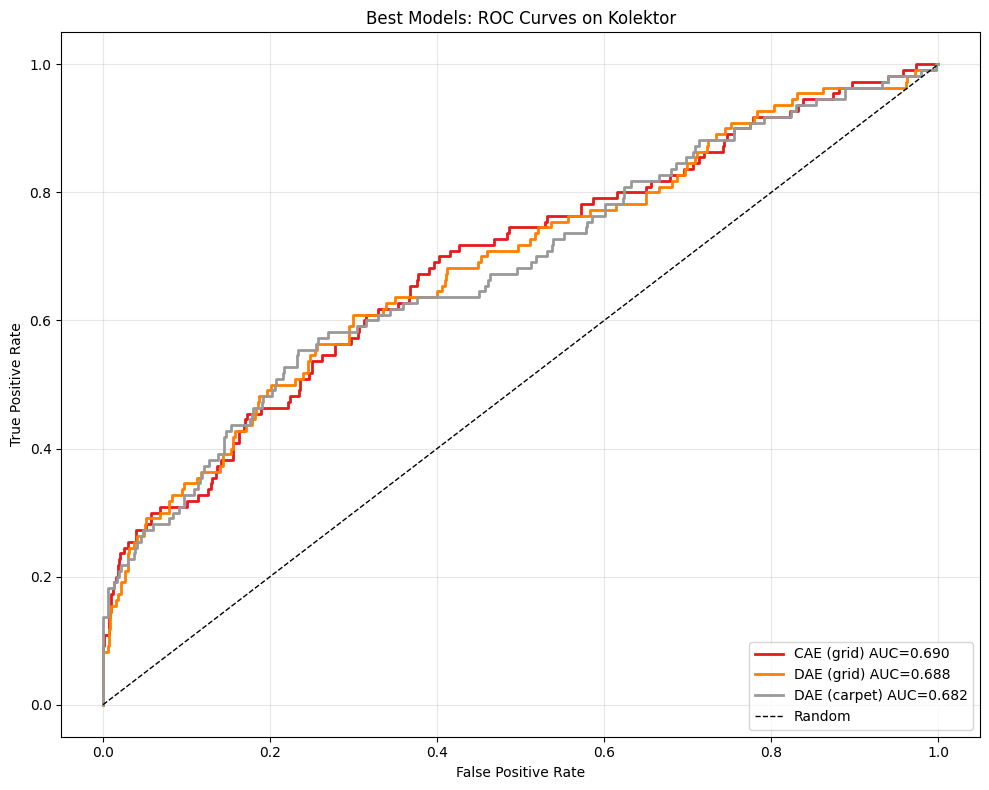

In [ ]:
# Best ROC curves
if roc_data:
    # Find top 3 models
    valid_results = df_results.dropna()
    top_3 = valid_results.nlargest(3, 'kolektor_auc')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, len(top_3)))
    
    for (_, row), color in zip(top_3.iterrows(), colors):
        key = f"{row['model']}_{row['trained_on']}"
        if key in roc_data:
            labels, scores = roc_data[key]
            fpr, tpr, _ = roc_curve(labels, scores)
            ax.plot(fpr, tpr, color=color, linewidth=2, 
                    label=f"{row['model']} ({row['trained_on']}) AUC={row['kolektor_auc']:.3f}")
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Best Models: ROC Curves on Kolektor')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'cross_dataset_roc.png', dpi=150)
    plt.show()

## 5. Reconstruction Examples on Kolektor

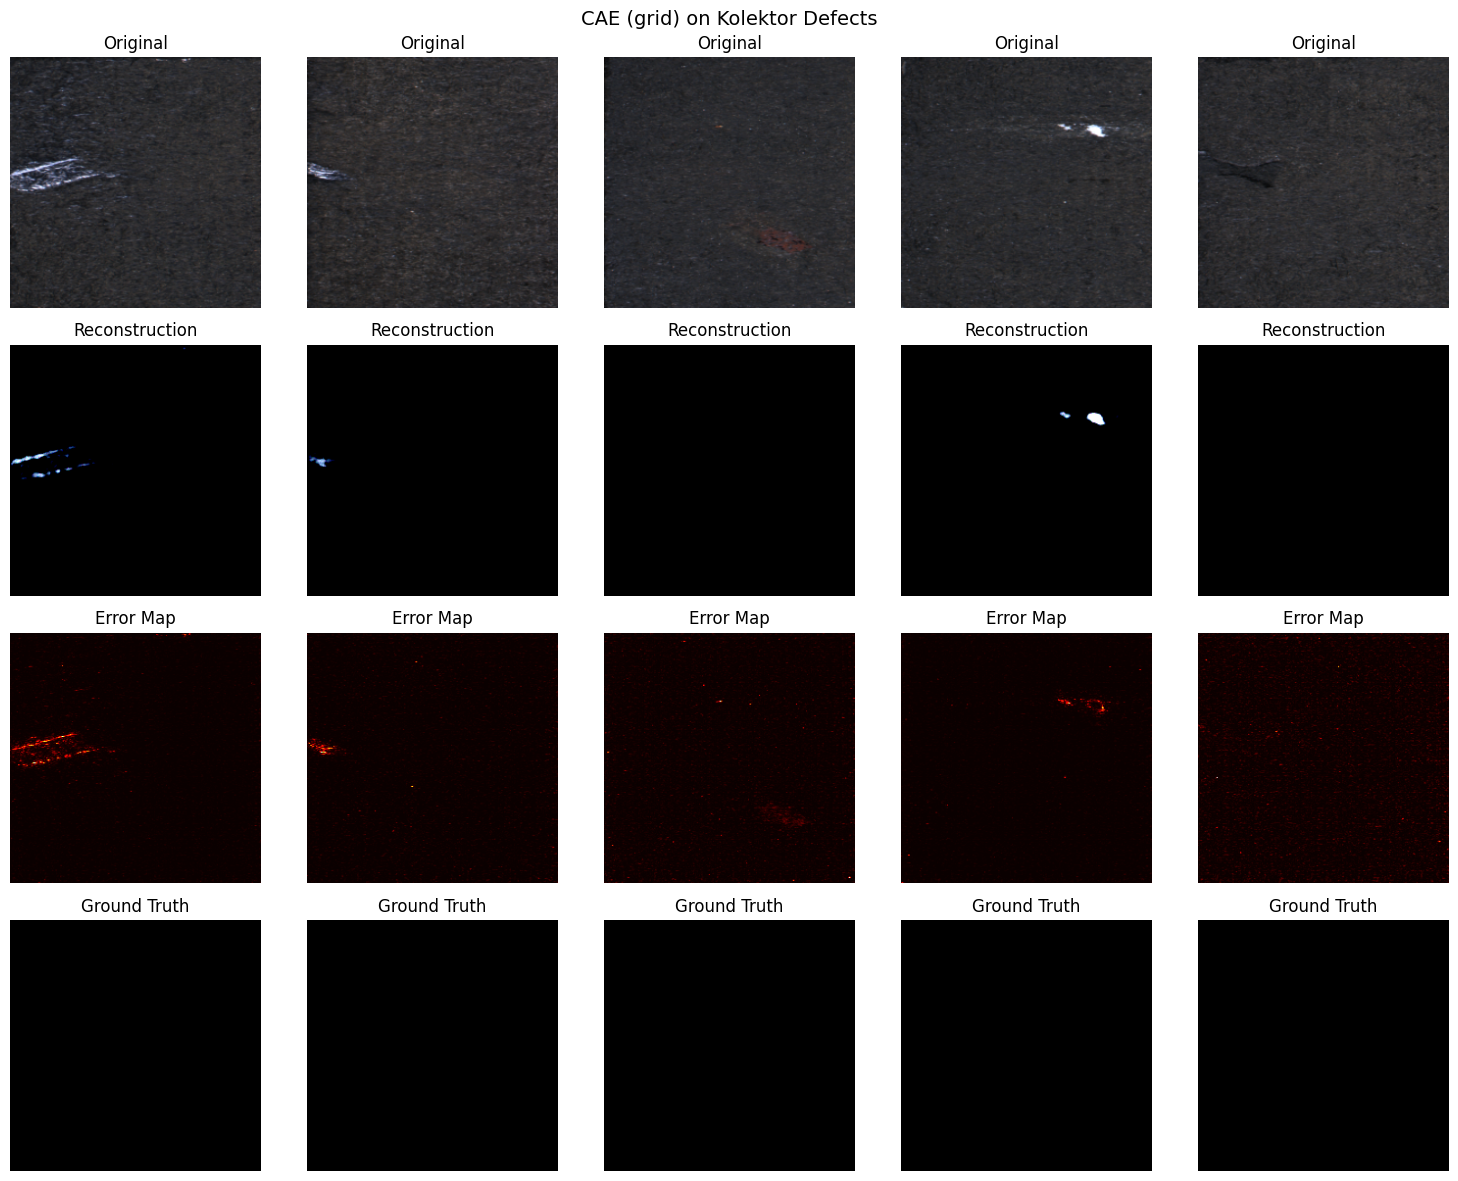

In [ ]:
# Load best CAE model
best_cae_row = df_results[df_results['model'] == 'CAE'].nlargest(1, 'kolektor_auc').iloc[0]
best_cae = load_model('CAE', best_cae_row['trained_on'])

if best_cae is not None:
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    
    # Get defect samples
    sample_indices = defect_indices[:5]
    
    for col, idx in enumerate(sample_indices):
        img, mask, label = kolektor_test[idx]
        img_input = img.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            recon = best_cae(img_input)
            error = best_cae.get_anomaly_map(img_input)
        
        img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
        recon_np = recon[0].cpu().permute(1, 2, 0).numpy().clip(0, 1)
        error_np = error[0, 0].cpu().numpy()
        mask_np = mask[0].numpy()
        
        axes[0, col].imshow(img_np)
        axes[0, col].set_title('Original')
        axes[0, col].axis('off')
        
        axes[1, col].imshow(recon_np)
        axes[1, col].set_title('Reconstruction')
        axes[1, col].axis('off')
        
        axes[2, col].imshow(error_np, cmap='hot')
        axes[2, col].set_title('Error Map')
        axes[2, col].axis('off')
        
        axes[3, col].imshow(mask_np, cmap='gray')
        axes[3, col].set_title('Ground Truth')
        axes[3, col].axis('off')
    
    plt.suptitle(f"CAE ({best_cae_row['trained_on']}) on Kolektor Defects", fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'cross_dataset_reconstructions.png', dpi=150)
    plt.show()

## 6. Summary Statistics

In [ ]:
if not df_results.empty:
    print("="*60)
    print("CROSS-DATASET GENERALIZATION SUMMARY")
    print("="*60)
    
    # Average by model type
    print("\nAverage AUC by Model Type:")
    for model_type in ['CAE', 'VAE', 'DAE']:
        valid = df_results[df_results['model'] == model_type]['kolektor_auc'].dropna()
        if len(valid) > 0:
            print(f"  {model_type}: {valid.mean():.4f} ± {valid.std():.4f}")
    
    # Best overall
    best = df_results.dropna().nlargest(1, 'kolektor_auc').iloc[0]
    print(f"\nBest Generalization:")
    print(f"  {best['model']} trained on '{best['trained_on']}': AUC = {best['kolektor_auc']:.4f}")
    
    # Save results
    df_results.to_csv(OUTPUTS_DIR / 'kolektor_generalization_results.csv', index=False)
    print(f"\nResults saved to: outputs/kolektor_generalization_results.csv")
    
    print("\n" + "="*60)

CROSS-DATASET GENERALIZATION SUMMARY

Average AUC by Model Type:
  CAE: 0.6563 ± 0.0223
  VAE: 0.5333 ± 0.0022
  DAE: 0.6385 ± 0.0406

Best Generalization:
  CAE trained on 'grid': AUC = 0.6901

Results saved to: outputs/kolektor_generalization_results.csv

